# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv


Якщо не вдається завантажиит з Kaggle, ось тут можна - https://drive.google.com/file/d/1kfu5zCRsDHxoBZigBlGIcCieKlws02HT/view?usp=sharing

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv("train-3.csv")
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [7]:
df = df.dropna()

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [10]:
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

У датасеті є три класи: positive, negative, neutral. Класи розподілені нерівномірно.

In [13]:
df['text_length'] = df['text'].apply(len)

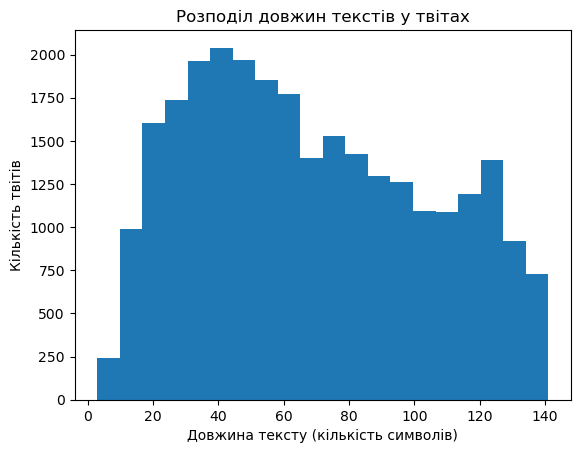

In [15]:
plt.figure()
plt.hist(df['text_length'], bins=20)
plt.xlabel("Довжина тексту (кількість символів)")
plt.ylabel("Кількість твітів")
plt.title("Розподіл довжин текстів у твітах")
plt.show()

Найбільше твітів довжиною 40-45 символів та в радіусі +- 20 від цих значень. Найменше - довжиною 0-10 символів. Твітів довжиною 60-125 також досить багато. Не має дуже довгих твітів.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [19]:
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/elena/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/elena/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [21]:
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

def stem_tokenizer(text):
    text = text.lower()

    # Очистка тексту від символів
    text = re.sub(r'[^a-z0-9\s!?]', '', text)
    # Замінюю 3 і більше однакові букви на 2
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
        
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [stemmer.stem(t) for t in tokens]
    
    return tokens

Видаляю всі символи окрім ! та ? оскільки вони можуть нести смислове навантаження.

В словнику залишаю тільки ті слова що зустрічаються 3 та більше разів, вказавши параметр min_df=3. Це відповідає max_features = 5644. Але якість класифікації зменшилася лише при min_df=7.

In [24]:
vectorizer = CountVectorizer(tokenizer=stem_tokenizer, min_df=3)

In [26]:
%%time
vectorizer.fit(df.text)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 2.35 s, sys: 23.8 ms, total: 2.37 s
Wall time: 2.38 s


CountVectorizer(min_df=3, tokenizer=<function stem_tokenizer at 0x349ac5da0>)

In [27]:
X = vectorizer.fit_transform(df['text'])

# Рахую частоти слів
word_counts = np.asarray(X.sum(axis=0)).ravel()
word_freq = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'count': word_counts
})
word_freq = word_freq.sort_values('count', ascending=False)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [28]:
word_freq

,word,count
0,!,13203
164,?,3846
2541,im,3059
1356,day,2373
2142,go,2363
...,...,...
2513,ia,3
4646,stabl,3
2514,iam,3
2516,ibm,3


In [30]:
%%time
inputs = vectorizer.transform(df.text)

CPU times: user 2.3 s, sys: 17.6 ms, total: 2.32 s
Wall time: 2.32 s


### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [32]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment,
                                                                        test_size=0.3, random_state=42, stratify=df.sentiment)

In [33]:
%%time
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 2.36 s, sys: 18.8 ms, total: 2.38 s
Wall time: 2.38 s


In [35]:
# XGB приймає тільки числовий таргет, тому перетворюю
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [37]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)
}

for name, model in models.items():
    model.fit(X_train_bow, y_train)
    y_pred = model.predict(X_test_bow)
    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("\n")

=== Logistic Regression ===
Accuracy: 0.6814653081028627
              precision    recall  f1-score   support

           0       0.69      0.62      0.65      2334
           1       0.63      0.72      0.67      3335
           2       0.76      0.69      0.72      2575

    accuracy                           0.68      8244
   macro avg       0.69      0.68      0.68      8244
weighted avg       0.69      0.68      0.68      8244



=== Random Forest ===
Accuracy: 0.6783114992721979
              precision    recall  f1-score   support

           0       0.68      0.60      0.64      2334
           1       0.64      0.69      0.66      3335
           2       0.72      0.74      0.73      2575

    accuracy                           0.68      8244
   macro avg       0.68      0.68      0.68      8244
weighted avg       0.68      0.68      0.68      8244



=== XGBoost ===
Accuracy: 0.7017224648229015
              precision    recall  f1-score   support

           0       0.75   

In [38]:
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'negative': 0, 'neutral': 1, 'positive': 2}


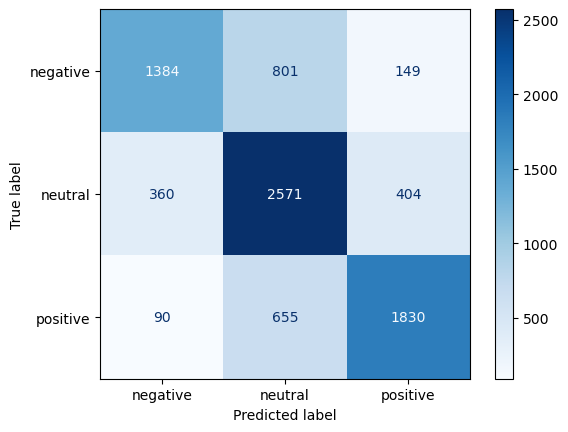

In [45]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2]) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap='Blues')

Найкраще спрацювала модель XGBoost за f1, якість класифікації гарна. Але трохи гірше модель розпізнає negative класс, ніж інші.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [48]:
importances = model.feature_importances_

feature_names = vectorizer.get_feature_names_out()  # масив слів
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

print(feat_imp_df.head(20))

     feature  importance
3899   thank    0.007605
1836   happi    0.006943
1849    hate    0.005593
2410    love    0.004822
2003    hurt    0.004488
3361     sad    0.004397
2727    nice    0.004191
3774    suck    0.003981
557     bore    0.003885
369   awesom    0.003789
1766   great    0.003767
1458    fail    0.003624
235     amaz    0.003618
937     cool    0.003474
1361   enjoy    0.003103
3505    sick    0.003103
4116     ugh    0.003061
2626  mother    0.003050
1423   excit    0.003035
3630   sorri    0.002993


Усе виглядає логічно: слова з сильним емоційним забарвленням (love, hate, great, fail) мають високу важливість.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=stem_tokenizer, min_df=3)

In [57]:
%%time
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 2.44 s, sys: 28.7 ms, total: 2.47 s
Wall time: 2.47 s


In [59]:
model_tfidf = XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)

model_tfidf.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [60]:
y_pred = model_tfidf.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("\n")

Accuracy: 0.6949296458030082
              precision    recall  f1-score   support

           0       0.75      0.58      0.65      2334
           1       0.63      0.77      0.69      3335
           2       0.76      0.71      0.73      2575

    accuracy                           0.69      8244
   macro avg       0.71      0.68      0.69      8244
weighted avg       0.71      0.69      0.69      8244





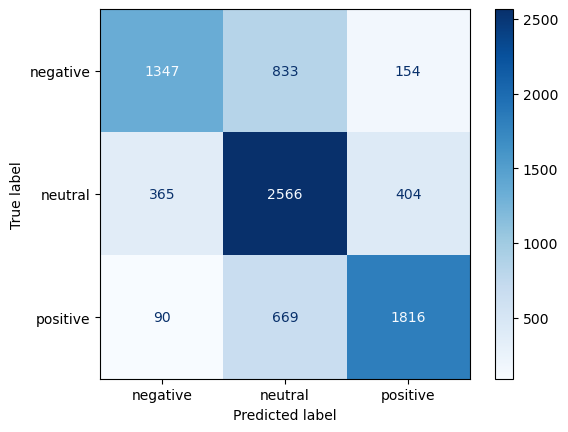

In [63]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2]) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap='Blues')

In [593]:
importances = model_tfidf.feature_importances_

feature_names = tfidf_vectorizer.get_feature_names_out() 
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

print(feat_imp_df.head(20))

     feature  importance
1238   happi    0.006810
2582   thank    0.006778
1246    hate    0.005346
2213     sad    0.004877
1614    love    0.004696
2496    suck    0.004367
1809    nice    0.004323
385     bore    0.004031
975     fail    0.004029
1752  mother    0.003930
163     amaz    0.003920
1187   great    0.003894
1354    hurt    0.003837
257   awesom    0.003613
650     cool    0.003516
2316    sick    0.003425
2737     ugh    0.003367
2400   sorri    0.003269
705     cute    0.003198
1724    miss    0.003080


При використанні TF-IDF векторизації точність моделі (по f1) трохи зменшилася порівняно з Bag of Words, тому фінально я б обрала CountVectorizer. 

Аналіз топ-токенів показав, що обидва методи векторизації виділяють ключові слова з емоційною забарвленістю, такі як thank, happi, hate, love, sad. Це логічно, адже ці слова безпосередньо впливають на визначення сентименту.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [67]:
errors_df = pd.DataFrame({
    'text': X_test.reset_index(drop=True),
    'true_label': y_test,
    'pred_label': y_pred,
})

mistakes = errors_df[errors_df.true_label != errors_df.pred_label]
pd.set_option('display.max_colwidth', None)
mistakes.head(20)

,text,true_label,pred_label
2,"wearing a pair of trousers that were loose last year, tight this year",0,1
12,"unfortunetly no I wish, I mean sometimes like twice a yr they`ll have a party, but not always",0,2
15,"Time to get ready for wrk! Ahhhh, I dnt wanna goooo!",0,1
16,is wondering y Mother Nature is making my life miserable,0,2
18,not so good,0,2
19,bout tuh head out an find sum wher tuh go an chill,2,1
20,_precious06 sooo mad,1,0
22,What? I focused on Tom so much I didn`t see my beloved Barack! Oh no! I must vote for both! Poor president only has 626 votes.,1,0
23,i have three hours to do my hair. and it STILL won`t be straight,0,1
24,"I assume you mean 2nd item with 3 nested lines, but no invert call tree button to be found ï¿½ ï¿½ ï¿½",0,1


Класифікатор помиляється, оскільки не враховує контекст слів і не розрізняє, коли слово змінює своє значення в комбінації з іншими словами. Наприклад, слово “good” окремо сприймається як позитивне, але у фразі “not good” воно передає негативний сенс. Тому варто спробувати не видаляти разом зі стоп-словами такі слова як 'no', 'not'. Можливо такі як 'don't', 'won't' також. (Приклади: 'not so good', '#BGT DCD Seniors were good, but not good enough.').

Також часто зустрічаються в твітах слова замінені на \*. Вони можуть означати "погані" слова. Твітів з символами '****' вдвічі більше negative ніж positive та neutral. Тому при передобробці варто зберегти ці символи якщо їх 2 підряд чи більше.
Аналогічно зі смайлами, наприклад: ((.

Також зустрічаються орфографічні помилки. Можна спробувати замінити ці слова на коректні перед стеммінгом.

Та варто попрацювати над підбором гіперпараметрів та порогом класифікації.

In [70]:
substring = '**'
mask = df['text'].str.contains(re.escape(substring), case=False, na=False)
result = df[mask]
result.head(10)

,textID,text,selected_text,sentiment,text_length
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,75
30,d33f811375,I`m going home now. Have you seen my new twitter design? Quite....heavenly isn`****?,Quite....heavenly,positive,84
41,fab6b7d16c,im an avid fan of **** magazine and i love your magazines,avid fan of,positive,57
53,11084dac09,it is ****...u have dissappointed me that past few days,it is ****...u have dissappointed me that past few days,negative,56
107,40649553ef,haha I do not know how to work blip apart from the obvious! thanks for reblipping my song have a nice day ****,thanks,positive,112
176,557e676fe4,I miss my neice can`t wait to see her bad n grown ****! Lol,miss,negative,61
204,e6ee6826df,I AM SUCH A CREEPER I feel disappointed because of it. **** my cyberstalking skills the internet = no more privacy.,I AM SUCH A CREEPER I feel disappointed because of it. **** my cyberstalking skills the internet = no more privacy,negative,118
248,6402e14398,"Wolverine Was BOSS! Seriously, And Will.I.Am Was In It, What The **** ??","Seriously,",negative,72
254,c5645758be,"Trying to decide on a movie with the friends.. not going to well! lol :p No bible study 2nite, which means ****-day cake buy my own??",not going to well!,negative,135
272,52d8be9124,huh what the ****? Smelly? Noooo. I love alex Vixon,huh what the ****? Smelly? Noooo. I love alex Vixon,neutral,52


In [72]:
result['sentiment'].value_counts()

sentiment
negative    538
neutral     263
positive    218
Name: count, dtype: int64

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model